## Imports

In [ ]:
import os
import glob
import datetime

import jax
import numpyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hssm
import arviz as az
import seaborn as sns

import sqlite3

jax.config.update('jax_platform_name', 'cpu')
hssm.set_floatX("float32")
numpyro.set_host_device_count(14)

In [ ]:
df_raw = pd.read_stata('Data_Exp1234_clean.dta')

In [ ]:
df_raw

## Definitions

In [ ]:
def subsitute_values_sequential(data,varname,new_values):
  unique_values = sorted(data[varname].unique())
  substitutions = {val: new_val for val, new_val in zip(unique_values,new_values)}
  return  data[varname].replace(substitutions)

In [ ]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / (mad if mad>0 else np.finfo(float).eps)

In [ ]:
def fit_hssm_participant(df, participant_column):
    all_summaries = []
    all_inferences = {}   # <- store InferData here

    for nsub, isub in enumerate(df[participant_column].unique()):
        print(f"___Participant {isub}, {nsub+1}/{df[participant_column].nunique()}___")

        df_sub = df[df[participant_column] == isub].drop(columns=[participant_column])

        print("Median RT =", np.median(df_sub['rt']))
        print("N trials =", len(df_sub))

        model = hssm.HSSM(
            model="ddm",
            data=df_sub,
        )

        infer_data_sub = model.sample(
            cores=3,
            chains=3,
            draws=300,
            tune=1000,
            idata_kwargs=dict(log_likelihood=True),
            progressbar=True,
            target_accept=0.99,
        )

        all_inferences[isub] = infer_data_sub

        summary_df = (
            az.summary(infer_data_sub)
              .reset_index()
              .rename(columns={'index': 'param'})
        )
        summary_df['participant_id'] = isub
        all_summaries.append(summary_df)

    all_summaries_df = pd.concat(all_summaries, ignore_index=True)
    return all_summaries_df, all_inferences

In [ ]:
def write_to_sql(df, db_name, table_name):
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists="append", index=False)
    conn.close()

### Data Cleanup

In [ ]:
columns_to_keep = [
    'id',              # Participant ID (for hierarchical fitting)
    'trial',           # Trial Number (for indexing/sequencing)
    'experiment',      # Filter column (must be 4)
    'rt',              # Response Time (The dependent variable distribution)
    'correct',         # Accuracy (The outcome predicted by DDM)
    'ab_nominal',      # Accuracy Bonus (Incentive condition)
    'stake_nominal',   # Loss Size (Incentive condition)
    'difficult',        # Task Difficulty (Signal quality condition)
    'endowment',      # Initial amount (Incentive con
]

In [ ]:
data = df_raw.copy()
data = data[columns_to_keep]

data.rename(columns={
    'id':'participant'
}, inplace=True)

## Stim evidence: low vs high (0/1)
#data['endowment_2'] = subsitute_values_sequential(data,'stim_strength',[0.25,.5,0.75,1])

MIN_RT = 200 
MAX_RT = 35000 
MAD_THRESH_RT = 3

ACC_THRESH_LO = 0.525 
ACC_THRESH_HI = 0.975

MIN_TRIALS_PER_COND = 8
COND_VARS = ['endowment']

#count original number of trials before exclusion
n_trials_raw= len(data)

In [ ]:
data = data[(~data['correct'].isna()) & (~data['rt'].isna())
             & (data['rt']> MIN_RT) & (data['rt'] < MAX_RT) & (~data['correct'].isna())]

In [ ]:
data = data[data.groupby('participant')['rt'].transform(lambda x: abs(robust_z(x)))<MAD_THRESH_RT]

In [ ]:
print('N trials excluded = %i / %i'%(n_trials_raw - len(data),n_trials_raw))

print('Mean RT = %i ms, median RT = %i ms, max RT = %i ms' % (data['rt'].mean(),data['rt'].median(),data['rt'].max()))

In [ ]:
data

## Participant Cleanup

In [ ]:
participant_accuracy = data.groupby('participant')['correct'].mean()
valid_participants = participant_accuracy[(participant_accuracy > ACC_THRESH_LO) & (participant_accuracy < ACC_THRESH_HI)].index

print('N participants kept (accuracy) = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

#remove participants with extreme median RTs compared to sample
participant_rt = data.groupby('participant')['rt'].median()
valid_participants_rt = participant_rt[np.abs(robust_z(participant_rt))<3].index
print('N participants kept (RT) = %i / %i'%(len(valid_participants_rt),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants_rt)]

# remove participants, who, after exclsion, have too few trials for one or more conditions
groupby_vars = ['participant']
groupby_vars.extend(COND_VARS)
sub_trials_per_cond = data.groupby(groupby_vars).size().reset_index(name='n_trials')

#get list of participants that have at least min_trials_per_cond trials per condition (combination of incentive and desirability values)
df_participants_with_min_trials = sub_trials_per_cond.groupby('participant').filter(lambda x: (x['n_trials'] >= MIN_TRIALS_PER_COND).all())
valid_participants = df_participants_with_min_trials['participant'].unique().tolist()
print('N participants kept after excluding participants with too few trials = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

In [ ]:
data = data[data['experiment']==4]

## HSSM DataFrame

In [269]:
data

,participant,trial,experiment,rt,correct,ab_nominal,stake_nominal,difficult,endowment
63495,708.0,1.0,4.0,1454.6,0,0.05,0.0,3.0,0.0
63496,708.0,2.0,4.0,2016.7,0,0.05,0.0,0.0,0.0
63497,708.0,3.0,4.0,959.7,1,0.05,0.0,0.0,0.0
63498,708.0,4.0,4.0,910.2,1,0.05,0.0,3.0,0.0
63499,708.0,5.0,4.0,1021.8,0,0.05,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
97552,1113.0,79.0,4.0,1329.4,1,10.00,1.0,0.0,5.0
97553,1113.0,80.0,4.0,1506.9,1,10.00,1.0,1.0,5.0
97554,1113.0,81.0,4.0,1345.2,1,10.00,1.0,0.0,5.0
97555,1113.0,82.0,4.0,2321.0,0,10.00,1.0,3.0,5.0


In [270]:
df_hssm = pd.DataFrame({
    'response': data['correct'].astype('int32'),
    'rt': (data['rt'] / 1000).astype('float32'),
    'participant_id': data['participant'].astype('int32')
})

df_hssm = df_hssm.astype({col: 'float32' for col in df_hssm.select_dtypes(include='float64').columns})

In [271]:
df_hssm

,response,rt,participant_id
63495,0,1.4546,708
63496,0,2.0167,708
63497,1,0.9597,708
63498,1,0.9102,708
63499,0,1.0218,708
...,...,...,...
97552,1,1.3294,1113
97553,1,1.5069,1113
97554,1,1.3452,1113
97555,0,2.3210,1113


# Test dataset

In [313]:
random_ids = np.random.choice(
    df_hssm.participant_id.unique(),
    size=round(len(df_hssm.participant_id.unique())/5),
    replace = False
)

In [314]:
df_test = df_hssm[df_hssm['participant_id'].isin(random_ids)]

In [315]:
df_hssm.participant_id.nunique(), df_test.participant_id.nunique()

(314, 63)

In [316]:
df_test

,response,rt,participant_id
63588,0,1.1872,709
63589,1,1.0333,709
63590,0,1.8186,709
63591,0,0.9463,709
63592,1,1.4090,709
...,...,...,...
97020,1,4.1956,1107
97021,1,5.7743,1107
97022,1,1.9394,1107
97023,1,1.1090,1107


# Partial dataset for fitting

In [317]:
part_df = df_test.copy()

In [318]:
fitted_participantd_ids = pd.read_sql_query("SELECT DISTINCT participant_id FROM summaries", sqlite3.connect('hssm_fits.db'))

In [319]:
len(fitted_participantd_ids)

300

In [320]:
df_test

,response,rt,participant_id
63588,0,1.1872,709
63589,1,1.0333,709
63590,0,1.8186,709
63591,0,0.9463,709
63592,1,1.4090,709
...,...,...,...
97020,1,4.1956,1107
97021,1,5.7743,1107
97022,1,1.9394,1107
97023,1,1.1090,1107


In [321]:
part_df = df_test[~df_test['participant_id'].isin(fitted_participantd_ids.participant_id.values)]

In [322]:
part_df.participant_id.nunique()

34

## Fit model

In [323]:
df_fit_output, az_data = fit_hssm_participant(part_df, 'participant_id')

___Participant 709, 1/34___
Median RT = 1.5371
N trials = 85


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 720, 2/34___
Median RT = 1.22575
N trials = 78


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 755, 3/34___
Median RT = 1.45365
N trials = 66


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 762, 4/34___
Median RT = 1.3299
N trials = 81


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 765, 5/34___
Median RT = 2.3583
N trials = 91


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 775, 6/34___
Median RT = 1.4665
N trials = 95


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 795, 7/34___
Median RT = 2.2809
N trials = 66


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 802, 8/34___
Median RT = 2.7347
N trials = 88


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 804, 9/34___
Median RT = 1.38205
N trials = 80


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 822, 10/34___
Median RT = 1.3724
N trials = 93


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 865, 11/34___
Median RT = 2.9235
N trials = 67


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 869, 12/34___
Median RT = 2.85715
N trials = 70


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 879, 13/34___
Median RT = 2.6936
N trials = 59


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 882, 14/34___
Median RT = 1.9186
N trials = 77


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 891, 15/34___
Median RT = 1.6459
N trials = 79


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 895, 16/34___
Median RT = 1.4798
N trials = 91


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 902, 17/34___
Median RT = 1.5155001
N trials = 68


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 61 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 907, 18/34___
Median RT = 2.56855
N trials = 80


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 911, 19/34___
Median RT = 2.1953502
N trials = 62


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 917, 20/34___
Median RT = 1.7591
N trials = 63


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 918, 21/34___
Median RT = 1.9416
N trials = 71


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 928, 22/34___
Median RT = 2.487
N trials = 63


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 941, 23/34___
Median RT = 1.5985
N trials = 65


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 963, 24/34___
Median RT = 1.4515
N trials = 67


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 966, 25/34___
Median RT = 1.6675
N trials = 86


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 971, 26/34___
Median RT = 2.44785
N trials = 82


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 996, 27/34___
Median RT = 2.36245
N trials = 54


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 997, 28/34___
Median RT = 1.6472499
N trials = 62


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1004, 29/34___
Median RT = 2.1613
N trials = 55


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1019, 30/34___
Median RT = 1.9168501
N trials = 72


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1029, 31/34___
Median RT = 0.895
N trials = 63


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1053, 32/34___
Median RT = 2.1649
N trials = 82


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1055, 33/34___
Median RT = 0.9542
N trials = 67


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 1105, 34/34___
Median RT = 1.365
N trials = 87


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [331]:
df_fit_output

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,0.117,0.135,-0.119,0.360,0.006,0.004,573.0,628.0,1.00,709
1,t,0.629,0.034,0.561,0.686,0.002,0.001,306.0,354.0,1.00,709
2,a,1.044,0.057,0.935,1.151,0.003,0.002,429.0,491.0,1.00,709
3,z,0.536,0.038,0.462,0.604,0.002,0.001,555.0,668.0,1.00,709
4,v,0.585,0.219,0.192,1.001,0.015,0.011,212.0,469.0,1.00,720
...,...,...,...,...,...,...,...,...,...,...,...
131,z,0.641,0.048,0.563,0.735,0.002,0.002,380.0,479.0,1.01,1055
132,v,0.470,0.164,0.196,0.789,0.010,0.007,287.0,632.0,1.01,1105
133,t,0.661,0.041,0.589,0.730,0.002,0.002,308.0,514.0,1.01,1105
134,a,0.952,0.054,0.846,1.045,0.003,0.002,290.0,299.0,1.01,1105


# store data

In [332]:
write_to_sql(df_fit_output, 'hssm_fits.db', 'summaries')

# az plot

In [333]:
#az.plot_posterior(az_data[1080])

# Drift rate plots

In [334]:
df_v = df_fit_output[df_fit_output['param']=='v']

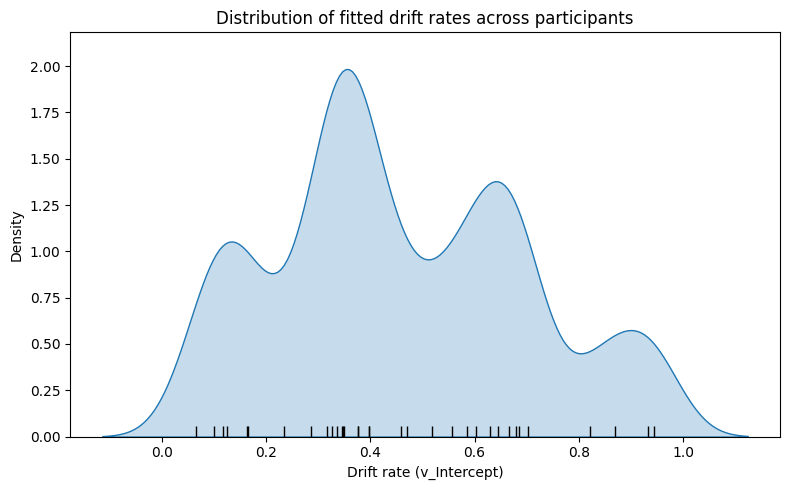

In [335]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_v['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v['mean'], color='k')
plt.xlabel("Drift rate (v_Intercept)")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()

# Read SQL

In [336]:
query = "SELECT * FROM summaries WHERE param='v'"
conn = sqlite3.connect('hssm_fits.db')
df_v_all = pd.read_sql_query(query, conn)
conn.close()

In [337]:
df_v_all[df_v_all['participant_id']>708]

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
14,v,0.513,0.174,0.213,0.866,0.010,0.007,312.0,261.0,1.01,935
15,v,0.634,0.150,0.347,0.903,0.008,0.005,396.0,539.0,1.01,1062
16,v,0.504,0.129,0.256,0.744,0.007,0.005,341.0,386.0,1.01,1081
17,v,0.388,0.099,0.214,0.575,0.005,0.003,482.0,446.0,1.01,1109
30,v,0.175,0.138,-0.070,0.436,0.013,0.009,120.0,360.0,1.04,832
...,...,...,...,...,...,...,...,...,...,...,...
377,v,0.680,0.178,0.385,1.078,0.010,0.007,342.0,421.0,1.01,1019
378,v,0.821,0.280,0.281,1.272,0.014,0.010,410.0,565.0,1.01,1029
379,v,0.346,0.123,0.111,0.587,0.006,0.004,392.0,528.0,1.00,1053
380,v,0.235,0.253,-0.215,0.715,0.013,0.009,392.0,424.0,1.00,1055


# Clean db

In [338]:
query_delete = "DELETE FROM summaries WHERE participant_id<708"